In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import glob
import os

In [2]:
# figure plotting preferences 

dpi = 200 # resolution
fs = 20 # fontsize

In [13]:
def generate_rho_T(pn,fn,pn_bh,x_bh,sensorids):

    # load raw fata
    
    data_raw = ert.load(pn+fn) 

    survey_name=fn
    plotmodel=True

    # calculate geometric factor and apparent resistivity if not already in data file

    if data_raw.haveData('k')==False:
        if max(np.array(data_raw.sensors()).T[2])-min(np.array(data_raw.sensors()).T[2])==0: # is it flat?
            data_raw['k'] = ert.createGeometricFactors(data_raw) # no need for numerical solution
        else: # topography
            data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation

    if data_raw.haveData('rhoa')==False:
        if data_raw.haveData('r')==False:
            data_raw['r'] = data_raw['u']/data_raw['i']
        data_raw['rhoa'] = data_raw['r']*data_raw['k'] 
        
    # some datasets had problematic cables. if so, remove those data points
    
    if sensorids is not None:
        data_raw.removeSensorIdx(sensorids)

    mgr = ert.ERTManager(data_raw)

    # inversion parameters
    
    mgr.inv.inv.setBlockyModel(True)

    data_raw['err'] = ert.estimateError(
    data_raw, 
    absoluteError=0.001, 
    relativeError=0.04 # % noise
    )

    # run inversion

    mod = mgr.invert(
        data_raw,
    )

    # getting lambda, chi2, rms error

    lam = mgr.inv.inv.getLambda()
    chi2 = mgr.inv.inv.getChi2()
    rms = np.sqrt(np.mean(((data_raw['rhoa']-mgr.inv.response)/data_raw['rhoa'])**2))*100

    # plot results
    
    fig, ax = plt.subplots(1,1,figsize=[13,5])

    ax, cBar = mgr.showResult(
       mod,
        ax=ax,
        cMap='turbo_r',
        coverage=mgr.coverage(),
        cMin=100,
        cMax=15000,
        orientation='vertical',
    )
    
    # colorbar

    cBar.set_label('')
    cBar.ax.tick_params(labelsize=fs-4) 
    cBar.ax.set_title(r'$\rho$ ($\Omega$m)'+ '\n',fontsize=fs,rotation=270, y=0.35,x=5)
    
    # get axis limits and trim figure automatically
    
    Ex = np.array(data_raw.sensors()).T[0]
    Ey = np.array(data_raw.sensors()).T[1]
    xmin = min(Ex)
    xmax = max(Ex)
    ymin = mgr.paraDomain.yMin()
    ymax = mgr.paraDomain.yMax()
    trim_ymin = ymin + (ymax-ymin)/3
    ax.set_ylim([trim_ymin,ymax+abs(ymax-ymin)*0.07])
    ax.set_xlim([xmin,xmax])
    
    # figure details - electrodes, rms error, axis labels
    
    ax.plot(Ex,Ey,'ko')
    ax.text(xmin+(xmax-xmin)*0.02,trim_ymin+(ymax-trim_ymin)*0.1,'RMS error=%.1f%%'%(rms),fontsize=fs)
    ax.tick_params(axis='both', labelsize=fs-4)
    ax.set_xlabel('X (m)',fontsize=fs)
    ax.set_ylabel('Z (m)',fontsize=fs)
    
    # plot borehole location
    
    ax.plot([x_bh,x_bh],[ymin,Ey[Ex==x_bh]],color='k',linewidth=4)
    
    # calculate coverage filter from sensitivity (using pygimli script)

    def addCoverageAlpha(coverage, dropThreshold=0.4):

        C = np.asarray(coverage)
        C = C[~np.isnan(C)]
        #    print(np.min(C), np.max(C))

        if (np.min(C) < 0.) | (np.max(C) > 1.) | (np.max(C) < 0.5):

            nn, hh = np.histogram(C, 50)
            nnn = nn.cumsum(axis=0) / float(len(C))

            #        print("min-max nnn ", min(nnn), max(nnn))
            mi = hh[np.min(np.where(nnn > 0.02)[0])]

            if np.min(nnn) > dropThreshold:
                ma = np.max(C)
            else:
                ma = hh[np.max(np.where(nnn < dropThreshold)[0])]
    #            mi = hh[min(np.where(nnn > 0.2)[0])]
    #            ma = hh[max(np.where(nnn < 0.7)[0])]

            C = (C - mi) / (ma - mi)
            C[np.where(C < 0.)] = 0.0
            C[np.where(C > 0.95)] = 1.0

        return(C)

    # interpolate results onto regular grid
    
    E = np.array(data_raw.sensors()).T[0]

    # get values from triangular mesh 
    
    Xm = np.array(mgr.paraDomain.cellCenters()).T[0]
    Ym = np.array(mgr.paraDomain.cellCenters()).T[1]
    Rm = np.array(mod)
    
    # make new grid
    
    xg = np.arange(min(E),max(E)+0.001,min(np.diff(E))/2)
    yg = np.arange(np.round(min(Ym),1),np.round(max(Ym),1)+0.1,0.1)
    [Xg,Yg]=np.meshgrid(xg,yg)

    # interpolate resistivity and coverage onto new grid
    
    from scipy.interpolate import griddata
    Cov = addCoverageAlpha(mgr.coverage())
    Rg = griddata(np.array( (Xm.flatten(), Ym.flatten()) ).T, Rm.flatten(), np.array((Xg.flatten(), Yg.flatten()) ).T,  method='linear')
    Cg = griddata(np.array( (Xm.flatten(), Ym.flatten()) ).T, Cov.flatten(), np.array((Xg.flatten(), Yg.flatten()) ).T,  method='linear')

    # load borehole data

    data_bh = pd.read_excel(pn_bh)

    z_bh = np.array(data_bh.keys())
    T_bh = data_bh.iloc[0].values
    
    # find resistivity at borehole loc
    
    Rhog = np.reshape(Rg,np.shape(Xg))

    y_corr = Yg.T[0]- Ey[np.where(Ex==x_bh)][0] # borehole depth -> elevation
    Rho_bh = Rhog[np.where(Xg==x_bh)]

    R_atT = []

    for i in range(len(z_bh)):
        R_atT.append(Rho_bh[np.where(abs(y_corr-z_bh[i])==min(abs(y_corr-z_bh[i])))[0][0]])

    R_atT = np.array(R_atT)

    R_plt = R_atT[~np.isnan(R_atT)]
    z_plt = z_bh[~np.isnan(R_atT)]
    T_plt = T_bh[~np.isnan(R_atT)]

    # plot temperature resistivity curve

    cmap = plt.get_cmap('rainbow', len(T_plt))

    fig, ax = plt.subplots(1,1,figsize=[6,5])

    for i in range (len(T_plt)):
        plt.scatter(T_plt[i], R_plt[i]/1000,100,color=cmap(i),label='z=%sm'%z_plt[i],zorder=0)

    plt.legend(fontsize=fs-9)

    plt.xlabel(r'Temperature ($\degree$C)',fontsize=fs)
    plt.ylabel(r'Resistivity (k$\Omega$m)',fontsize=fs)

    ax.tick_params(axis='both', which='major', labelsize=fs-2)

    T_th = -0.00 

    # fit T>0 and T<0

    # frozen 
    
    px_f = T_plt[T_plt<T_th] 
    py_f = R_plt[T_plt<T_th]

    # unfrozen 
    
    px_uf = T_plt[T_plt>T_th]
    py_uf = R_plt[T_plt>T_th]

    coeff1 = np.poly1d(np.polyfit(px_uf,py_uf, 1)) # unfrozen
    coeff2 = np.poly1d(np.polyfit(px_f,py_f, 1))

    a,b = list(coeff1)
    c,d = list(coeff2)

    # find intersection point of two lines

    xth = (d-b)/(a-c)

    xn = np.linspace(xth,max(T_plt))
    p_uf = np.poly1d(coeff1)
    p_f = np.poly1d(coeff2)

    yth = p_uf(xth)

    # plot lines
     
    pad = 0.5
    plt.plot(np.linspace(min(T_plt)-pad,xth),p_f(np.linspace(min(T_plt)-pad,xth))/1000,'k--')
    plt.plot(np.linspace(xth,max(T_plt)+pad),p_uf(np.linspace(xth,max(T_plt)+pad))/1000,'k:')

    plt.plot(xth,yth/1000,'k*',markersize=10,)

    plt.text(xth+0.2,yth/1000+0.5,'(%.2f,%.1f)'%(xth,yth/1000),fontsize=fs-2)

    return T_plt,R_plt,p_f,p_uf,xth,yth

24/02/25 - 21:29:44 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 186): /Users/teddiherringnew/Library/Caches/pygimli/3077484105639835686
24/02/25 - 21:29:44 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 21:29:44 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 21:29:44 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 21:29:44 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 21:29:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 21:29:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 21:29:44 - pyGIMLi - INFO - Use median(data values)=4372.5192210406085
24/02/25 - 21:29:44 - pyGIMLi - INFO - Created startmodel from forward operator: 981 [4372.5192210406085,...,4372.5192210406085

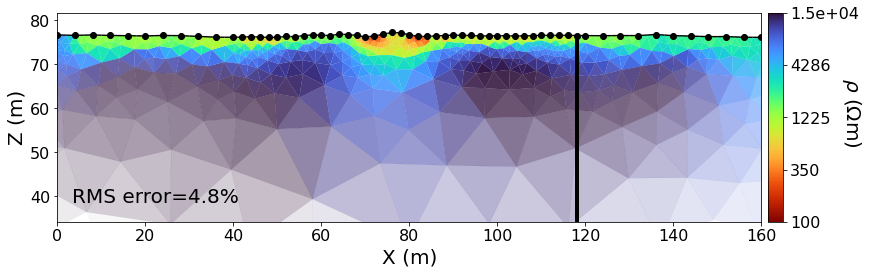

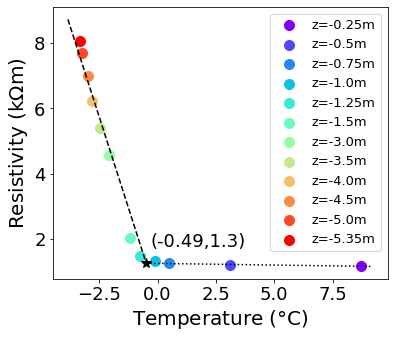

In [11]:
T_belch,R_belch,p_f_belch,p_uf_belch,x_th_belch,y_th_belch = generate_rho_T(
    pn = 'formatted ert data/summer 2023/',
    fn = '20230903 BELC W160.txt',
    pn_bh = 'borehole data/Belch_01_09.xlsx',
    x_bh = 118,
    sensorids = None
)

24/02/25 - 21:34:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 45): /Users/teddiherringnew/Library/Caches/pygimli/7165247469012375586
24/02/25 - 21:34:00 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 21:34:00 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 21:34:00 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 21:34:00 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 21:34:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 21:34:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 21:34:00 - pyGIMLi - INFO - Use median(data values)=2199.9311699038
24/02/25 - 21:34:00 - pyGIMLi - INFO - Created startmodel from forward operator: 600 [2199.9311699038,...,2199.9311699038]
/Users/t

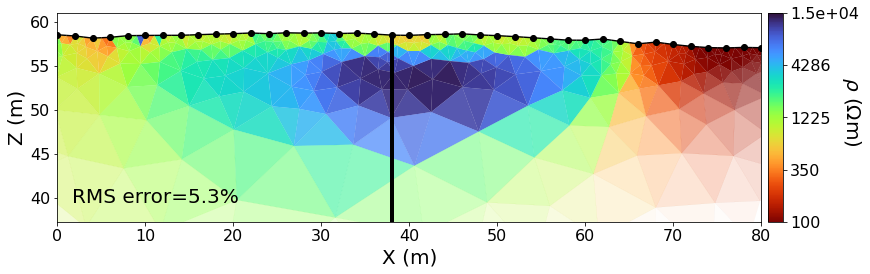

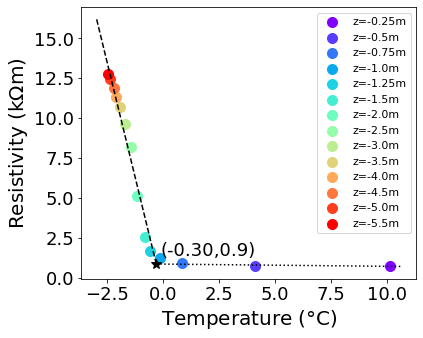

In [14]:
T_ches,R_ches,p_f_ches,p_uf_ches,x_th_ches,y_th_ches = generate_rho_T(
    pn = 'formatted ert data/summer 2024/',
    fn = 'CHESWenner_1-2024-09-02-200930.txt',
    pn_bh = 'borehole data/chesnaye_sept1_2024_1pm.xlsx',
    x_bh = 38,
    sensorids = None

)

24/02/25 - 21:25:51 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 27): /Users/teddiherringnew/Library/Caches/pygimli/7328434820446716859
24/02/25 - 21:25:51 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 21:25:51 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 21:25:51 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 21:25:51 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 21:25:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 21:25:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 21:25:51 - pyGIMLi - INFO - Use median(data values)=1983.8685427871465
24/02/25 - 21:25:51 - pyGIMLi - INFO - Created startmodel from forward operator: 662 [1983.8685427871465,...,1983.8685427871465]

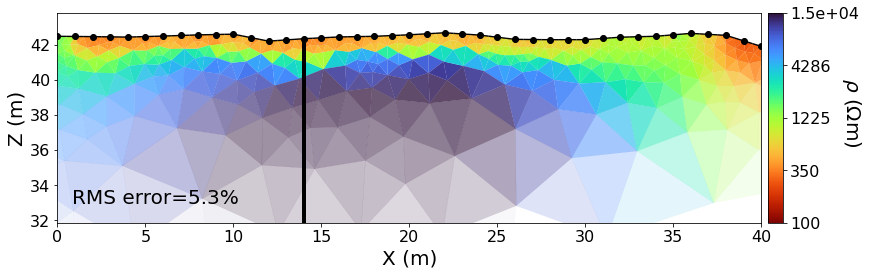

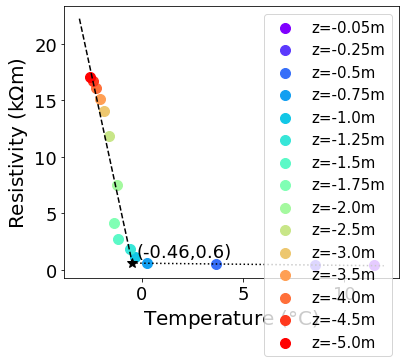

In [6]:
T_lamp,R_lamp,p_f_lamp,p_uf_lamp,x_th_lamp,y_th_lamp = generate_rho_T(
    pn = 'formatted ert data/summer 2024/',
    fn = 'Lamp_Wenner_60-2024-08-28-225047.txt',
    pn_bh = 'borehole data/lamprey_aug28_2024_3pm.xlsx',
    x_bh = 14,
    sensorids = None
)

24/02/25 - 21:26:00 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 45): /Users/teddiherringnew/Library/Caches/pygimli/8470057524136289617
24/02/25 - 21:26:00 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 21:26:00 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 21:26:00 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 21:26:00 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 21:26:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 21:26:00 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 21:26:00 - pyGIMLi - INFO - Use median(data values)=1408.044031507211
24/02/25 - 21:26:00 - pyGIMLi - INFO - Created startmodel from forward operator: 560 [1408.044031507211,...,1408.044031507211]
/U

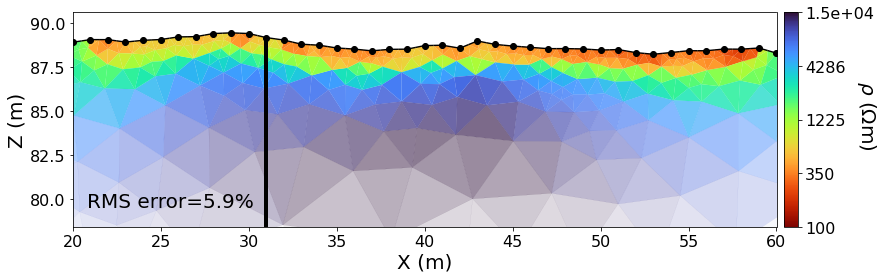

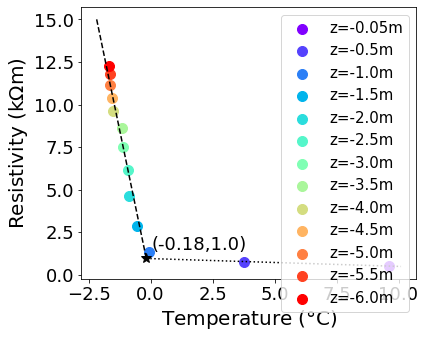

In [7]:
T_tbd2,R_tbd2,p_f_tbd2,p_uf_tbd2,x_th_tbd2,y_th_tbd2= generate_rho_T(
    pn = 'formatted ert data/summer 2024/',
    fn = 'TBD2Wenner_60-2024-08-28-225208.txt',
    pn_bh = 'borehole data/tbd2_aug28_2024_10am.xlsx',
    x_bh = 31,
    sensorids=np.arange(0,10)
)

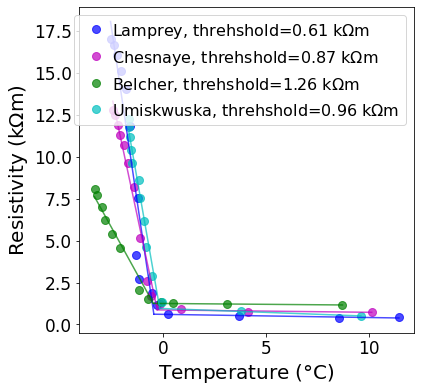

In [8]:
# plot all results

fig, ax = plt.subplots(1,1,figsize=[6,6])

cs = ['b','m','c','g',]

alp= 0.7
ms = 8
pad = 0.0
ls = '-'

ax.plot(T_lamp, R_lamp/1000,marker='o',linestyle='None',color=cs[0],label='Lamprey, threhshold=%.2f k$\Omega$m'%(y_th_lamp/1000),alpha=alp,markersize=ms)
ax.plot(T_ches, R_ches/1000,marker='o',linestyle='None',color=cs[1],label='Chesnaye, threhshold=%.2f k$\Omega$m'%(y_th_ches/1000),alpha=alp,markersize=ms)
ax.plot(T_belch, R_belch/1000,marker='o',linestyle='None',color=cs[3],label='Belcher, threhshold=%.2f k$\Omega$m'%(y_th_belch/1000),alpha=alp,markersize=ms)
ax.plot(T_tbd2, R_tbd2/1000,marker='o',linestyle='None',color=cs[2],label='Umiskwuska, threhshold=%.2f k$\Omega$m'%(y_th_tbd2/1000),alpha=alp,markersize=ms)

plt.plot(np.linspace(min(T_lamp)-pad,x_th_lamp),p_f_lamp(np.linspace(min(T_lamp)-pad,x_th_lamp))/1000,linestyle=ls,color=cs[0],alpha=alp)
plt.plot(np.linspace(x_th_lamp,max(T_lamp)+pad),p_uf_lamp(np.linspace(x_th_lamp,max(T_lamp)+pad))/1000,linestyle=ls,color=cs[0],alpha=alp)

plt.plot(np.linspace(min(T_ches)-pad,x_th_ches),p_f_ches(np.linspace(min(T_ches)-pad,x_th_ches))/1000,linestyle=ls,color=cs[1],alpha=alp)
plt.plot(np.linspace(x_th_ches,max(T_ches)+pad),p_uf_ches(np.linspace(x_th_ches,max(T_ches)+pad))/1000,linestyle=ls,color=cs[1],alpha=alp)

plt.plot(np.linspace(min(T_belch)-pad,x_th_belch),p_f_belch(np.linspace(min(T_belch)-pad,x_th_belch))/1000,linestyle=ls,color=cs[3],alpha=alp)
plt.plot(np.linspace(x_th_belch,max(T_belch)+pad),p_uf_belch(np.linspace(x_th_belch,max(T_belch)+pad))/1000,linestyle=ls,color=cs[3],alpha=alp)

plt.plot(np.linspace(min(T_tbd2)-pad,x_th_tbd2),p_f_tbd2(np.linspace(min(T_tbd2)-pad,x_th_tbd2))/1000,linestyle=ls,color=cs[2],alpha=alp)
plt.plot(np.linspace(x_th_tbd2,max(T_tbd2)+pad),p_uf_tbd2(np.linspace(x_th_tbd2,max(T_tbd2)+pad))/1000,linestyle=ls,color=cs[2],alpha=alp)

plt.legend(fontsize=fs-4,handletextpad=0)

plt.xlabel(r'Temperature ($\degree$C)',fontsize=fs)
plt.ylabel(r'Resistivity (k$\Omega$m)',fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs-3)

y1=7
yspc=1.5

fig.savefig('inverted results/rho_T_curves.png',format='png',dpi=dpi,bbox_inches='tight',facecolor='w')


In [9]:
# print threshold values

print('Resistivity threshold')
print(y_th_belch)
print(y_th_ches)
print(y_th_lamp)
print(y_th_tbd2)

print('')
print('Temperature threshold (freezing point)')
print(x_th_belch)
print(x_th_ches)
print(x_th_lamp)
print(x_th_tbd2)

Resistivity threshold
1255.801554576505
868.5801820003196
611.3603270998245
956.5246531668791

Temperature threshold (freezing point)
-0.4890847117537527
-0.2979778657824962
-0.463107319321417
-0.17771285335980788
